In [176]:
import os
import glob
import datetime
import importlib
import statistics
import numpy as np
import pandas as pd
from marcap import marcap_data
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from prettytable import PrettyTable

In [177]:
#import models.pbr_gpa as model # 1/PBR + GP/A
#import models.gpa as model
#import models.ncav as model # NCAV
#import models.super_value as model # PBR + PCR + PER + PSR
#import models.super_quality as model
#import models.lu_zhang as model
#import models.pbr as model
#import models.pcr as model
#import models.per as model
import models.psr as model
#import models.pbr_psr as model

importlib.reload(model)

<module 'models.psr' from '/home/pi/Documents/stock-backtesting/backtest-playground/quantitative-value/models/psr.py'>

In [178]:
#DATA_DIR = '../data/quarterly/2-5-8-11' # quarter
# DATA_DIR = '../data/half-year/2-8' # half year
DATA_DIR = '../data/yearly/8-1'
REBALANCE = 1 # 1: yearly, 2: half-yearly 4: quarterly

In [179]:
MIN_MARKET_CAP = 0.0
MAX_MARKET_CAP = 1.0
MARKET_CAP_STEP = 0.2

In [180]:
MIN_PER_RANK = 0.0
MAX_PER_RANK = 1.0
PER_RANK_STEP = 0.2

In [181]:
def get_cagr(min_market_cap, max_market_cap, min_per_rank, max_per_rank):
    df_account = pd.DataFrame(columns=['start_date', 'end_date', 'filepath'])
    filepaths = glob.glob(DATA_DIR + "/*.csv")
    filepaths = sorted(filepaths)

    days = []
    for i in range(len(filepaths)):
        if i < len(filepaths) - 1: # exclude last item
            start_date =  os.path.basename(filepaths[i])[:-4]
            end_date =  os.path.basename(filepaths[i + 1])[:-4]

            day = {'start_date':start_date, 'end_date':end_date, 'filepath':filepaths[i]}
            days.append(day)

    df_account = df_account.append(days)
    
    # 연도별 종목을 구한다.
    df_account['stocks'] = df_account.apply(lambda x: model.get_stocks(x.filepath, x.start_date, 
                                                                       min_market_cap, max_market_cap,
                                                                       min_per_rank, max_per_rank, 100, verbose=True), axis=1)
    
    
    # 연도별 수익률을 구한다.
    df_account['yield'] = 0.0
    df_account['yields'] = 0.0
    df_account['yields'] = df_account['yields'].astype('object')
    df_account['delisted'] = 0
    df_account['delisted_stocks'] = df_account['yields'].astype('object')

    for i in range(len(filepaths)):
        if i < len(filepaths) - 1: # exclude last item
            start_date = df_account.iloc[i].start_date
            end_date = df_account.iloc[i].end_date

            df_this_year = pd.read_csv(filepaths[i], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]
            df_next_year = pd.read_csv(filepaths[i + 1], dtype={"기업코드":"string", "종목코드":"string"})[['종목코드', '주가']]

            stocks = df_account.iloc[i].stocks   
            yields = []

            # 종목별 수익률, 상장폐지 기업 수를 구한다.
            delisted = 0 # 상장폐지 기업 수
            delisted_stocks  = []
            for stock in stocks:
                start_price = df_this_year[df_this_year['종목코드'] == stock]['주가'].iloc[0]
                end_price = df_next_year[df_next_year['종목코드'] == stock]['주가']

                if len(end_price) == 0:
                    end_price = 0
                else:                    
                    end_price = end_price.fillna(0) 
                    end_price = end_price.iloc[0]

                if end_price == 0: # 가격 정보가 없을 경우 상폐
                    delisted += 1
                    delisted_stocks.append(stock)

                # get yield
                yields.append(end_price / start_price)

            # stock 수익률들의 avg가 total 수익률이 된다. (동일 비중이기 때문에)
            mean_yields = statistics.mean(yields)
            df_account.at[i, 'yield'] = mean_yields
            df_account.at[i, 'yields'] = yields
            df_account.at[i, 'delisted'] = delisted
            df_account.at[i, 'delisted_stocks'] = delisted_stocks

            print(start_date, '~', end_date, ":", mean_yields)
            
    df_account['total'] = df_account['yield'].cumprod()
    df_account['cagr'] = 0.0
    
    cagr = pow(df_account['total'][len(df_account) - 1], 1/(len(df_account)/REBALANCE))
    
    return cagr

In [182]:
total_cagrs = []

In [183]:
for market_cap in reversed(np.arange(MIN_MARKET_CAP, MAX_MARKET_CAP, MARKET_CAP_STEP)):
    min_market_cap = market_cap
    max_market_cap = min_market_cap + MARKET_CAP_STEP
    
    cagrs = []
    
    for per_rank in np.arange(MIN_PER_RANK, MAX_PER_RANK, PER_RANK_STEP):
        min_per_rank = per_rank
        max_per_rank = min_per_rank + PER_RANK_STEP
        
        print(min_market_cap, max_market_cap, min_per_rank, max_per_rank)
        cagr = get_cagr (min_market_cap, max_market_cap, min_per_rank, max_per_rank)
        print(cagr - 1.0)
        cagrs.append(cagr)
        
    total_cagrs.append(cagrs)

0.8 1.0 0.0 0.2
------------------------------
2002-08-01 ../data/yearly/8-1/2002-08-01.csv
전체 1402
국외주식 제외 1402
가격정보 없는 기업 제외 1002
201
2002-08-01 선정 기업 수 40
------------------------------
2003-08-01 ../data/yearly/8-1/2003-08-01.csv
전체 1491
국외주식 제외 1491
가격정보 없는 기업 제외 1070
214
2003-08-01 선정 기업 수 42
------------------------------
2004-08-02 ../data/yearly/8-1/2004-08-02.csv
전체 1540
국외주식 제외 1540
가격정보 없는 기업 제외 1122
225
2004-08-02 선정 기업 수 45
------------------------------
2005-08-01 ../data/yearly/8-1/2005-08-01.csv
전체 1630
국외주식 제외 1629
가격정보 없는 기업 제외 1176
236
2005-08-01 선정 기업 수 47
------------------------------
2006-08-01 ../data/yearly/8-1/2006-08-01.csv
전체 1682
국외주식 제외 1681
가격정보 없는 기업 제외 1239
248
2006-08-01 선정 기업 수 49
------------------------------
2007-08-01 ../data/yearly/8-1/2007-08-01.csv
전체 1765
국외주식 제외 1760
가격정보 없는 기업 제외 1303
261
2007-08-01 선정 기업 수 52
------------------------------
2008-08-01 ../data/yearly/8-1/2008-08-01.csv
전체 1850
국외주식 제외 1841
가격정보 없는 기업 제외 1386
278
2008-08-01 선

In [184]:
total_cagrs

[[1.1425671888561277,
  1.1038996996391983,
  1.0957950712665587,
  1.023691927795177,
  0.974986370238269],
 [1.135422747479987,
  1.0592255195938078,
  1.0211381380919642,
  1.0096399682421766,
  0.9474216528546208],
 [1.1250388399190867,
  1.0612051873016548,
  1.065013811749946,
  1.003565054006845,
  1.0159092490752175],
 [1.204339068009553,
  1.1437992097760665,
  1.1207218584982395,
  1.1211624648942833,
  1.1933889209177029],
 [1.4180144877509295,
  1.365936453457947,
  1.3112805546567443,
  1.399174274472948,
  1.3617287801414037]]

In [185]:
total_cagrs = np.array(total_cagrs)

In [186]:
norm = plt.Normalize(total_cagrs.min(), total_cagrs.max())
cmap = plt.get_cmap('Greens')
cell_colors = cmap(norm(total_cagrs))

In [187]:
cell_text = [['%.2f%%' % ((j - 1.0)*100.0) for j in i] for i in total_cagrs]

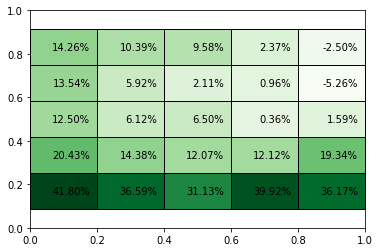

In [188]:
the_table=plt.table(cellText=cell_text, loc='center', cellColours=cell_colors)
the_table.scale(1, 3)
plt.show()